In [1]:
%run flow_tools.py

In [2]:
folders = [box_dir + 'BadIdea/Flow/20210401 - High Dose Cell Stim/',
           box_dir + 'BadIdea/Flow/20210401 - Low Dose Cell Stim/']

In [3]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Sender", "Receiver",
                                              'Ratio','Timepoint','Replicate'])
               for folder in folders])
df2 = clean_data(df)

In [4]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist.values[:,np.newaxis])
    k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Timepoint','Sender', 'Receiver','Ratio', 'Replicate'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


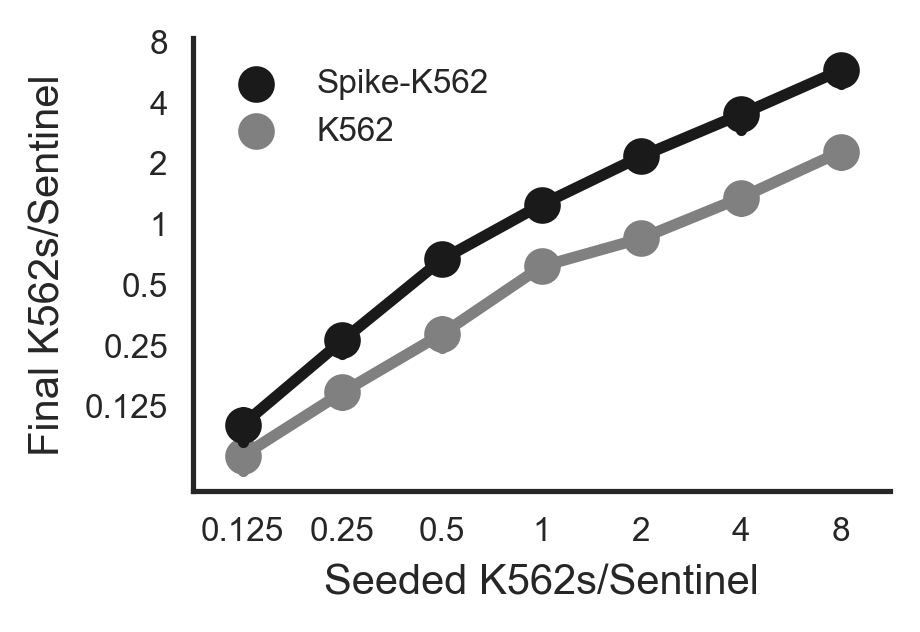

In [5]:
with sns.color_palette(['gray','k']):
    plt.figure(figsize=(3,2), dpi=300)
    output = (df2[(df2.Sender != 'None') &
                  (df2.Receiver != 'None') &
                  (df2.Timepoint == '72')]
              .groupby(['Sender','Receiver','Ratio','Replicate'])['Computed Density']
              .mean()
              .reset_index())
    g = sns.pointplot(data=output,
                  x='Ratio',y='Computed Density', hue='Sender', s=1,
                  order=['8:1', '4:1', '2:1','1:1', '1:2', '1:4','1:8'])
    plt.xlabel('Seeded K562s/Sentinel')
    plt.ylabel('Final K562s/Sentinel')
    plt.xticks([0,1,2,3,4,5,6],['0.125', '0.25', '0.5', '1', '2', '4', '8'])
    plt.yscale('log')
    plt.yticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
    g.axes.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([0.125, 0.25, 0.5, 1, 2, 4, 8]))
    handles, labels = g.axes.get_legend_handles_labels()
    g.legend().remove()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False)
    sns.despine()
    plt.savefig(outputdir + 'plating_density.svg')

In [6]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist.values[:,np.newaxis])
    k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Timepoint','Sender', 'Receiver','Ratio'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


In [7]:
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Timepoint','Computed Density', 'Ratio','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

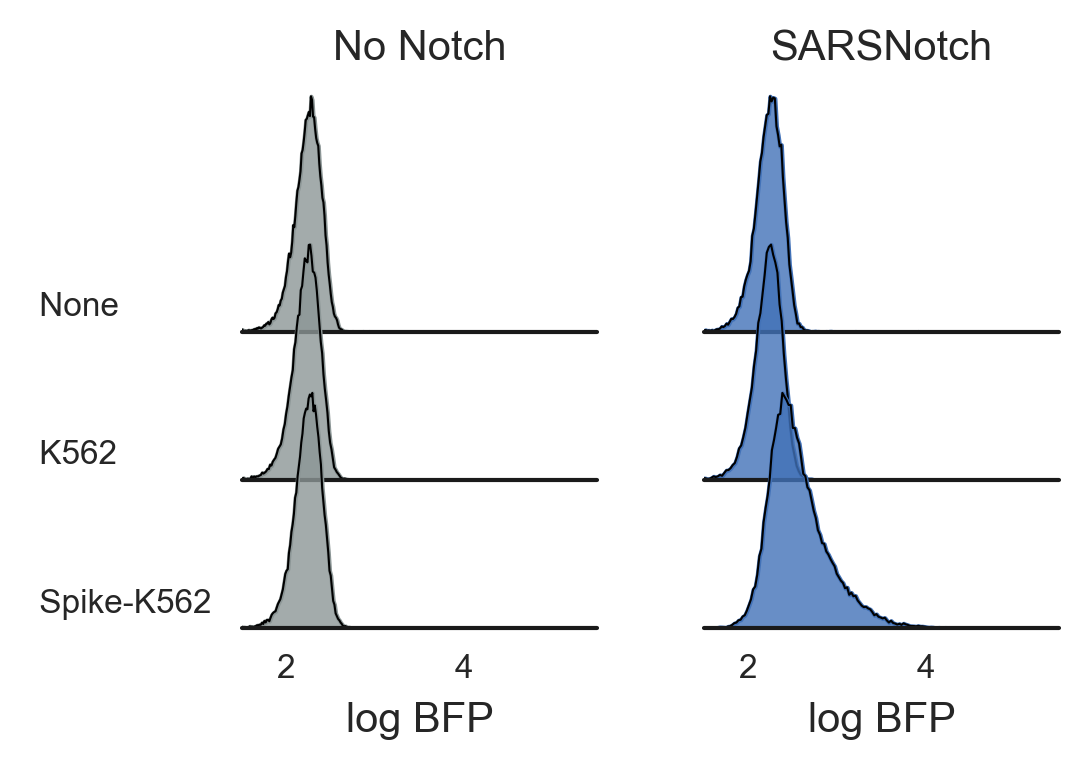

In [8]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    senders = ['None', 'K562', 'Spike-K562']
    notches = ['No Notch','SARSNotch']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Timepoint'] == '72') &
                               (df2['Ratio'].isin(['None','1:1'])) &
                               (df2['logFITC-A'] > 4)],
                      row='Sender', col = 'Receiver', sharey=False, aspect=2, height=0.8, 
                      hue='Receiver', row_order=senders, xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.6,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.set_xlabels("log BFP")
    g.fig.set_dpi(300)
    plt.savefig(outputdir+'jurkat_abridged_cell-cell_histogram.svg')

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


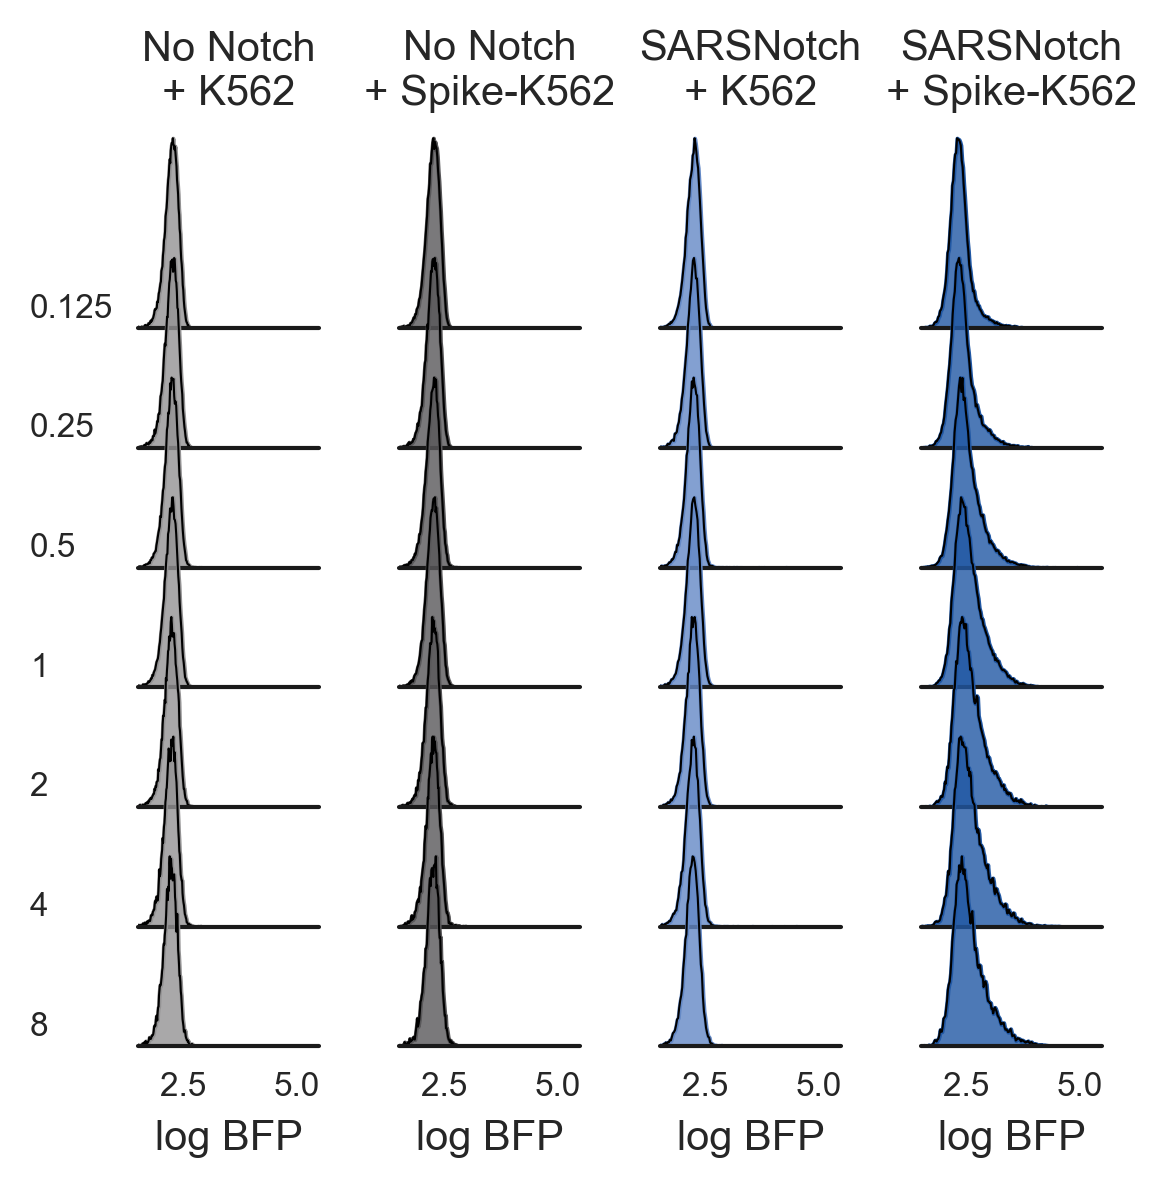

In [9]:
df2['Receiver/Sender'] = df2['Receiver'] + '\n+ ' + df2['Sender']
with sns.color_palette(["#949394",'#59585A', '#6489C6', "#2158A4"]):
    senders = ['K562', 'Spike-K562']
    notches = ['No Notch','SARSNotch']
    pairs = ['No Notch\n+ K562', 'No Notch\n+ Spike-K562', 'SARSNotch\n+ K562', 'SARSNotch\n+ Spike-K562']
    densities = ['0.125', '0.25', '0.5', '1', '2', '4', '8']
    ratio_order = ['8:1', '4:1', '2:1','1:1', '1:2', '1:4','1:8']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Timepoint'] == '72') &
                               (df2['Sender']).isin(senders) &
                               (df2['Ratio'] != 'None') &
                               (df2['logFITC-A'] > 4)],
                      row='Ratio', col = 'Receiver/Sender', sharey=False, aspect=1.8, height=0.5, 
                      hue='Receiver/Sender', col_order=pairs, hue_order=pairs, row_order = ratio_order, xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    left_axes = [g.facet_axis(r, 0) for r in range(len(densities))]
    for ax, density in zip(left_axes, densities):
        ax.text(-0.6,0.1, "{}".format(density), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(pairs))]
    for ax, pair in zip(top_axes, pairs):
        ax.set_title(pair)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.set_xlabels("log BFP")
    g.fig.set_dpi(300)
    plt.savefig(outputdir+'jurkat_cell-cell_histogram.svg')

In [10]:
receivers = ['SARSNotch', 'No Notch']
senders = ['K562', 'Spike-K562']
colors = {'No Notch + K562' : '#8C9696',
          'No Notch + Spike-K562' : '#6F7978',
          'SARSNotch + K562' : '#4272B8',
          'SARSNotch + Spike-K562' : '#2158A4'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}
markers = {'K562' : 'o', 'Spike-K562': '^'}

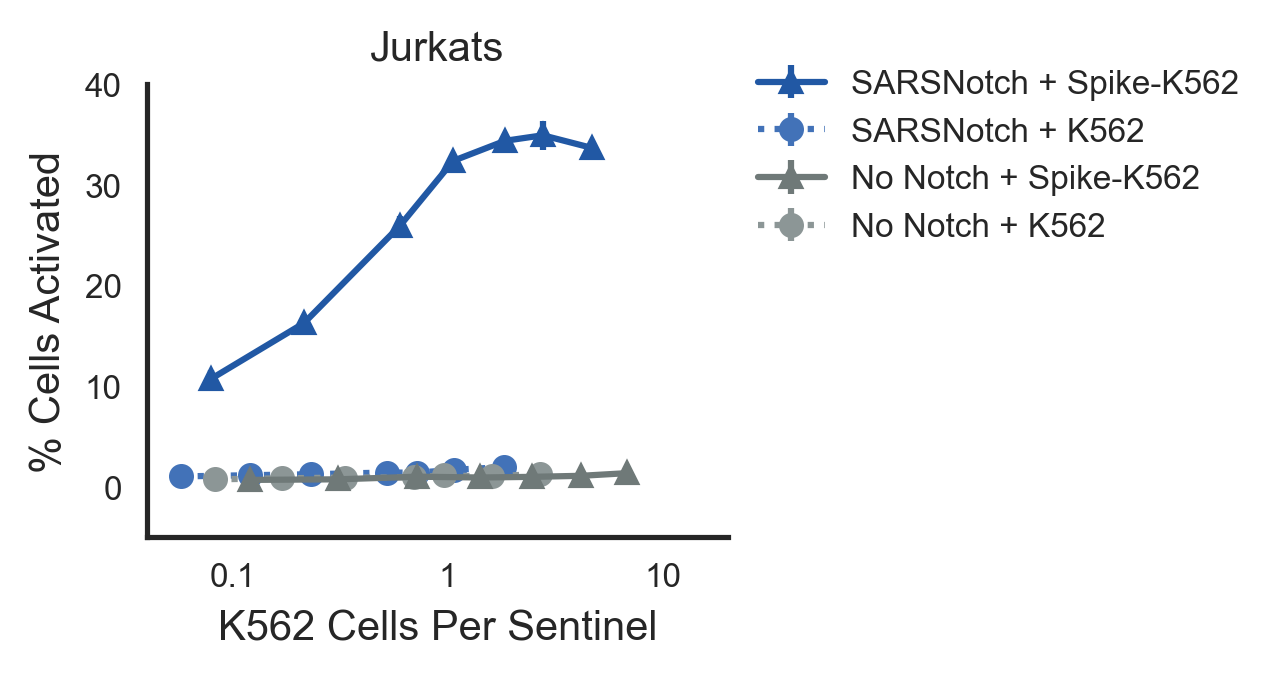

In [11]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']==sender) &
                                   (df_summary['Timepoint'] == '72')]
    output = (condition_summary
              .groupby('Computed Density')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Computed Density', ascending=True))
    ax.errorbar(output['Computed Density'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver + ' + ' + sender], 
                label=f'{receiver} + {sender}',
                marker=markers[sender], markersize=5, ls=linestyles[sender])

ax.set_xlabel('K562 Cells Per Sentinel')
ax.set_ylabel('% Cells Activated')
plt.xscale('log')
plt.ylim([-5,40])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.1))
sns.despine()
plt.title('Jurkats')
plt.xlim([4e-2,2e1])
def pretty_decimals(x, pos):
    return str(round(x, 1) if x % 1 else int(x))

ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(pretty_decimals))
plt.savefig(outputdir + 'cell_cell_response_jurkats.svg')

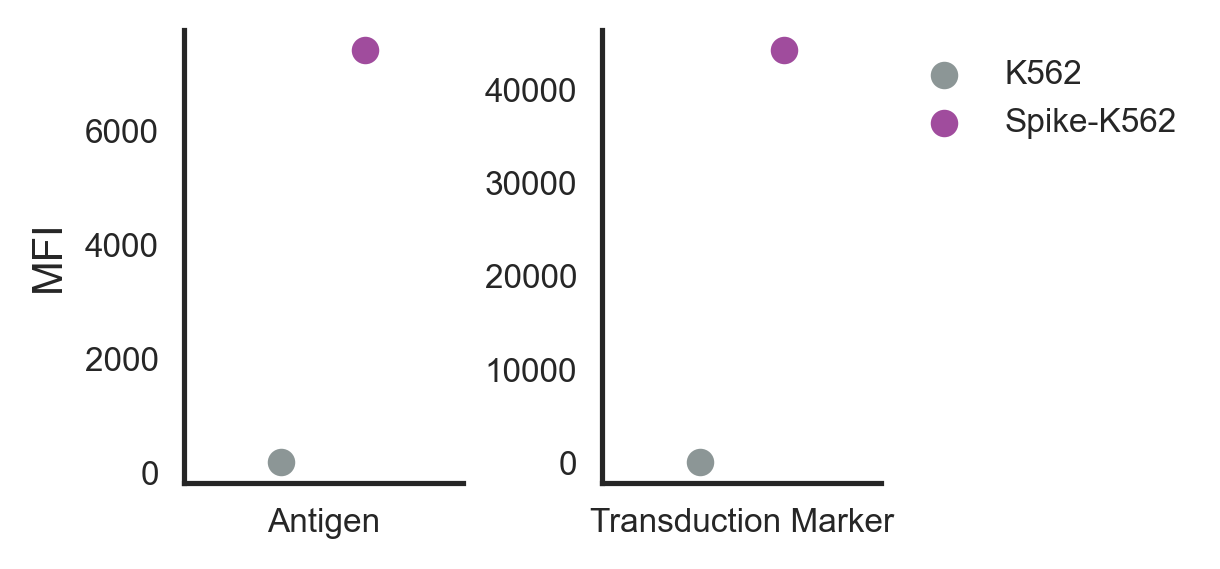

In [12]:
simplified_df = (df2[(df2['Sender'] != 'None') &
                     (df2['Receiver'] == 'None')]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','Sender','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['Sender','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'Antigen'

with sns.color_palette(['#8C9696', '#A04C9D']):
    fig, axs = plt.subplots(1,2, figsize=(3, 2), dpi=300)
    for channel, ax in zip(['Antigen', 'Transduction Marker'], axs):
        g = sns.pointplot(data=simplified_df[(simplified_df['Sender']).isin(['K562', 'Spike-K562']) &
                                             (simplified_df['channel'] == channel)], 
                          x='channel', y='counts', hue='Sender',
                          hue_order=['K562', 'Spike-K562'],
                          join=False, dodge=0.3, scale=0.75, ax=ax)
        g.legend().remove()
        g.set_xlabel('')
        g.set_ylabel('')
    axs[0].set_ylabel('MFI')
    axs[1].legend(frameon=False, loc='upper left', bbox_to_anchor=[1,1])
    plt.subplots_adjust(wspace=0.5)
    sns.despine()
    plt.savefig(outputdir + 'mfi_k562.svg')